In [1]:
import torch
import numpy as np
import datasets
import os
import umap
import evaluate
import accelerate
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from scipy.stats import spearmanr
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain
from numpy.lib.stride_tricks import sliding_window_view

from nbtools.sent_encoders.hf_models import from_hf
from nbtools.utils import (
    files,
    tensor_utils,
    display,
)
cache_dir=f'{files.project_root()}/cache'
display.note(f'cache_dir set to \'{os.getcwd()}\'')

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline


/data/john/projects/nb/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-11 20:55:17.396578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 20:55:18.042400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[NOTE] cache_dir set to '/data/john/projects/nb/notebooks/sofsat'


# Load a Dataset

In [5]:
ds = datasets.load_dataset(
    'cnn_dailymail',
    '1.0.0',
    cache_dir=cache_dir,
    trust_remote_code=True,
)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


# Get Sentence Counts for Test Set

avg len: 33.37006092254134
ratio of samples within limit (16): 0.1598
ratio of samples within limit (32): 0.5831
ratio of samples within limit (64): 0.9266
ratio of samples within limit (128): 0.9990
ratio of samples within limit (256): 1.0000


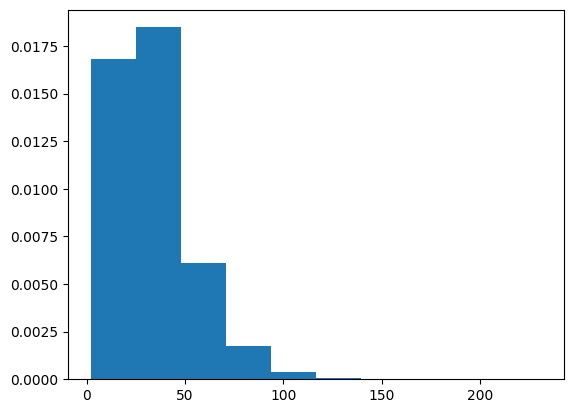

In [15]:
#lengths = np.array([len(sent_tokenize(x['article'])) for x in ds['test']])
num_proc = 10
#data = ds['train'][:]

def map_fn(x):
    return len(sent_tokenize(x['article']))

with Pool(num_proc) as p:
    counts = np.array(list(p.imap(
        map_fn,
        ds['test'],
    )))

#sent_counts = np.load('/data/john/files/wikipedia_sent_counts.npy')
print(f'avg len: {np.mean(counts)}')
_ = plt.hist(counts, density=True)

limits = np.array([16, 32, 64, 128, 256])
for limit in limits:
    print(f'ratio of samples within limit ({limit}): {len(counts[counts <= limit])/len(counts):.04f}')


# Load LLM and Make Text Format Function

In [ ]:
from langchain_community.llms import VLLM

llm = VLLM(
    model='mistralai/Mistral-7B-Instruct-v0.2',
    tensor_parallel_size=4,
    trust_remote_code=True,  # mandatory for hf models
)